In [1]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister
import qiskit
import numpy as np
import copy
import matplotlib.pyplot as plt

In [3]:
iris = datasets.load_iris()
X = iris.data[0:100]
Y = iris.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.33, random_state=42)

In [6]:
N = 4

In [7]:
def feature_map(X) :
    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q,c)
    
    for i, x in enumerate(X) :
        qc.rx(x, i)
        
    return qc, c

In [8]:
def variational_circuit(qc, theta):
    
    for i in range(N-1):
        qc.cnot(i, i+1)
    qc.cnot(N-1, 0)
    for i in range(N):
        qc.ry(theta[i], i)
    return qc

In [18]:
from qiskit.primitives import Sampler
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_quebec")
options = Options(resilience_level = 1) # 1 = measurement error mitigation
sampler = Sampler(backend)

In [19]:
def quantum_nn(X, theta, simulator=False):
    
    qc, c = feature_map(X)
    qc = variational_circuit(qc, theta)
    qc.measure(0,c)
    
    shots = 1E4
    backend = Aer.get_backend('qasm_simulator')
    
    if simulator == False:
        
        shots = 5000
        #provider = IBMQ.load_account()
        backend = service.backend("ibm_quebec")
        
    job = qiskit.execute(qc, backend, shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    return(counts['1']/shots)

#qc.draw('mpl')

In [20]:
def loss (prediction, target):
    return (prediction - target)**2

In [21]:
def gradient(X, Y, theta):
    
    delta = 0.01
    grad = []
    for i in range(len(theta)):
        
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        
        pred1 = quantum_nn(X, dtheta)
        pred2 = quantum_nn(X, theta)
        
        grad.append((loss(pred1, Y) - loss(pred2, Y)) / delta)
        
    return np.array(grad)

In [13]:
def accuracy(X, Y, theta):
    
    counter = 0
    for X_i, Y_i in zip(X, Y):
        
        prediction = quantum_nn(X_i, theta)
        
        if prediction < 0.5 and Y_i == 0:
            counter += 1
        elif prediction >= 0.5 and Y_i == 1:
            counter += 1
            
    return counter/len(Y)

In [ ]:
eta = 0.05
loss_list = []
theta = np.ones(N)

print('Epoch \t Loss \t Training Accuracy')

for i in range(20):
    
    loss_tmp = []
    for X_i, Y_i in zip(X_train, Y_train):

        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))
        theta = theta - eta * gradient(X_i, Y_i, theta)
        
    loss_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train, Y_train, theta)
    
    print(f'{i} \t {loss_list[-1]:.3f} \t {acc:.3f}')

Epoch 	 Loss 	 Training Accuracy


/tmp/ipykernel_341963/2434704148.py:4: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(i, i+1)
/tmp/ipykernel_341963/2434704148.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(N-1, 0)


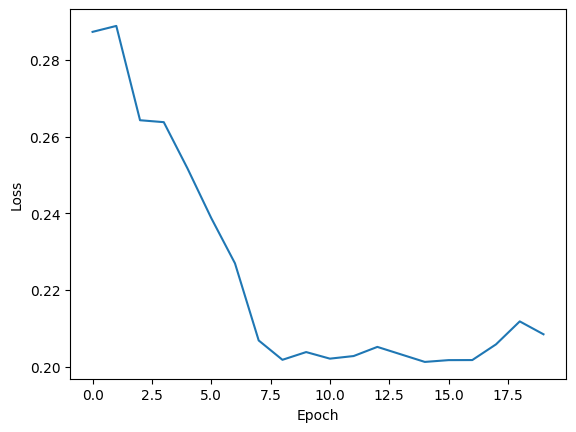

In [15]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [16]:
accuracy(X_test, Y_test, theta)

/tmp/ipykernel_341963/2434704148.py:4: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(i, i+1)
/tmp/ipykernel_341963/2434704148.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.cnot()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.cx as direct replacement.
  qc.cnot(N-1, 0)


0.7272727272727273